# Generating useful features for further analysis on Amazon reviews

## Introduction

**Business Context.** You are a business consultant with new clients that are interested in analyzing reviews of their products on Amazon (as opposed to Yelp). They want to answer business questions like: "What are the most important factors driving negative reviews?", "Have there been any large changes to customer satisfaction/reviews over time?", etc.

**Business Problem.** Your main task is to **explore the given data and use the results of your investigation to engineer relevant features that could facilitate subsequent analysis and model-building**.

**Analytical Context.** The dataset provided is a large body of reviews related to movies and television left on Amazon between 1996 and 2014. When exploring our dataset, we will quickly encounter a familiar problem we discussed in the previous case: the word "good" is one of the most important words in both positive *and* negative reviews. Thus, we must develop methods to put "good" in the appropriate context.

## Loading the data

We use a dataset of around 37,000 video reviews from Amazon Instant Video and 1,700,000 movie and TV reviews, all obtained from the website: http://jmcauley.ucsd.edu/data/amazon/. Note that there are much larger datasets available at the same site. We can expect better and more consistent results on larger datasets (such as book reviews). Note that these datasets are compressed (gzipped), and they are in [JSON](https://en.wikipedia.org/wiki/JSON) format, with each line representing a review and each line being its own JSON object.

We begin by loading the dataset below:

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

In [372]:
%%time
import gzip
import json
import string

import nltk # imports the natural language toolkit
import pandas as pd
import plotly

nltk.download('punkt')


# we can tell pandas that our file is in gzip format and it will handle the decompression for us
# we also use `lines=True` to indicate that each line of the file is its own JSON object
instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')


# ----------
# The Movies and TV file is very big. If you have problems loading it, you can load only the first 
# 100,000 reviews by using 'chunksize' (uncomment the line with 'chunksize' and comment out the line 
# after that which loads the entire file into `movies_tv`). All of the analysis can be 
# done in the same way using only the subset of reviews but some of the results might be different from the examples.
# ----------
movies_tv = next(pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip', chunksize=100000))
# movies_tv = pd.read_json("reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dcalle.MATONE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Wall time: 10.2 s


## Examining the data

We take a look at the first 5 rows of each dataset to see what attributes are available. These are

* **reviewerID:** A unique ID to identify the author of the review.
* **asin:** The ["Amazon Standard Identification Number"](https://www.amazon.com/gp/seller/asin-upc-isbn-info.html) which provides more information about the exact product and version.
* **reviewerName:** The username chosen by the reviewer.
* **helpful:** A record of how many users indicated that the review was helpful/not helpful.
* **reviewText:** The full text of the review.
* **overall:** The overall rating (1-5) left by the reviewer.
* **summary:** A short version of the review, used as the title.
* **unixReviewTime:** The date that the review was created, in [Unix Epoch](https://en.wikipedia.org/wiki/Unix_time) format.
* **reviewTime:** A human readable date giving the day, month, and year.
</font>

In [373]:
print(len(instant_video))
print(instant_video.head(5))

37126
       reviewerID        asin                    reviewerName helpful  \
0  A11N155CW1UV02  B000H00VBQ                        AdrianaM  [0, 0]   
1  A3BC8O2KCL29V2  B000H00VBQ                         Carol T  [0, 0]   
2   A60D5HQFOTSOM  B000H00VBQ  Daniel Cooper "dancoopermedia"  [0, 1]   
3  A1RJPIGRSNX4PW  B000H00VBQ                  J. Kaplan "JJ"  [0, 0]   
4  A16XRPF40679KG  B000H00VBQ                   Michael Dobey  [1, 1]   

                                          reviewText  overall  \
0  I had big expectations because I love English ...        2   
1  I highly recommend this series. It is a must f...        5   
2  This one is a real snoozer. Don't believe anyt...        1   
3  Mysteries are interesting.  The tension betwee...        4   
4  This show always is excellent, as far as briti...        5   

                          summary  unixReviewTime   reviewTime  
0      A little bit boring for me      1399075200   05 3, 2014  
1           Excellent Grown Up TV 

In [374]:
print(len(movies_tv))
print(movies_tv.head(5))

100000
       reviewerID        asin                         reviewerName helpful  \
0   ADZPIG9QOCDG5  0005019281  Alice L. Larson "alice-loves-books"  [0, 0]   
1  A35947ZP82G7JH  0005019281                        Amarah Strack  [0, 0]   
2  A3UORV8A9D5L2E  0005019281                      Amazon Customer  [0, 0]   
3  A1VKW06X1O2X7V  0005019281           Amazon Customer "Softmill"  [0, 0]   
4  A3R27T4HADWFFJ  0005019281                                 BABE  [0, 0]   

                                          reviewText  overall  \
0  This is a charming version of the classic Dick...        4   
1  It was good but not as emotionally moving as t...        3   
2  Don't get me wrong, Winkler is a wonderful cha...        3   
3  Henry Winkler is very good in this twist on th...        5   
4  This is one of the best Scrooge movies out.  H...        4   

                                        summary  unixReviewTime   reviewTime  
0                     good version of a classic      1

We notice that `movies_tv` is extremely long with nearly 2 million reviews, and several columns seem uninteresting or hard to work with (e.g. `reviewerID`, `asin`, `reviewername`, `reviewtime`). We drop some information to make some of our later analysis more efficient. We also add a datetime column with Python datetime objects to more easily summarize the data:

In [375]:
%%time
movies_tv['datetime'] = pd.to_datetime(movies_tv['reviewTime'], format="%m %d, %Y")
instant_video['datetime'] = pd.to_datetime(instant_video['reviewTime'], format="%m %d, %Y")

Wall time: 294 ms


In [376]:
movies_tv = movies_tv.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])
instant_video = instant_video.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])

movies_tv.head(5)

,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26
1,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22


### Exercise 1:

#### 1.1

Plot histograms of all numeric quantities. Do you notice anything interesting about them?

In [377]:
movies_tv['year'],movies_tv['month'] = movies_tv.datetime.dt.year, movies_tv.datetime.dt.month

In [378]:
%%time
series1 = list()
series2 = list()
for i in range(len(movies_tv.helpful)):
    series1.append(movies_tv.helpful[i][0]) # This line concatenates the series with the current item in the loop
    series2.append(movies_tv.helpful[i][1])
    
movies_tv['helpful_pos'] = pd.Series(series1)
movies_tv['helpful_neg'] = pd.Series(series2)

Wall time: 3.75 s


In [379]:
%%time
series1 = list()
series2 = list()
for i in range(len(instant_video.helpful)):
    series1.append(instant_video.helpful[i][0]) # This line concatenates the series with the current item in the loop
    series2.append(instant_video.helpful[i][1])
    
instant_video['helpful_pos'] = pd.Series(series1)
instant_video['helpful_neg'] = pd.Series(series2)
instant_video['year'],instant_video['month'] = instant_video.datetime.dt.year, instant_video.datetime.dt.month

Wall time: 1.45 s


In [380]:
movies_tv.head()
movies_tv.helpful_pos.value_counts()
# movies_tv.year.head()[0]

0      43922
1      19738
2      10471
3       6579
4       4381
       ...  
487        1
167        1
422        1
210        1
220        1
Name: helpful_pos, Length: 256, dtype: int64

[]

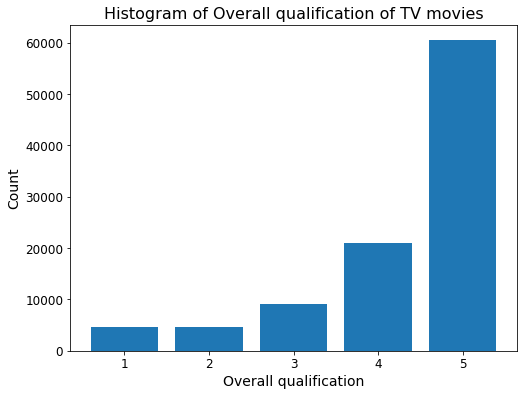

In [381]:
plt.hist(movies_tv.overall, bins = [1,2,3,4,5,6], rwidth = 0.8, align = 'left')
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.xlabel('Overall qualification', size = 14)
plt.ylabel('Count', size = 14)
plt.title('Histogram of Overall qualification of TV movies', size = 16)
plt.xticks(size = 12)
plt.yticks(size = 12)

plt.plot()

[]

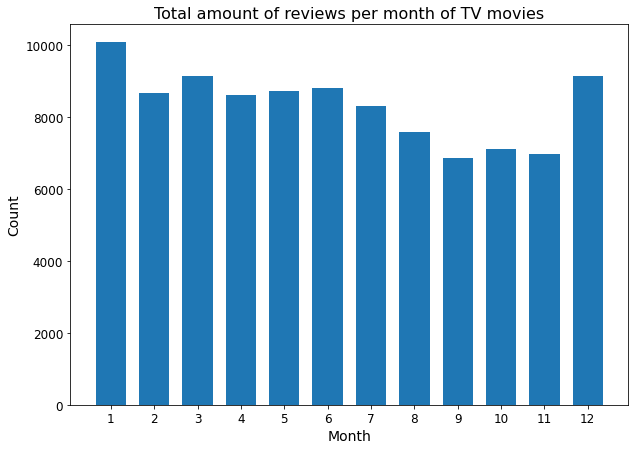

In [382]:
plt.hist(movies_tv.month, bins = range(1,14), rwidth = 0.7, align = 'left')
fig = plt.gcf()
ax = plt.gca()

fig.set_size_inches(10, 7)
plt.xlabel('Month', size = 14)
plt.ylabel('Count', size = 14)
plt.title('Total amount of reviews per month of TV movies', size = 16)
plt.xticks(range(13),size = 12)
plt.yticks(size = 12)
plt.plot()

[]

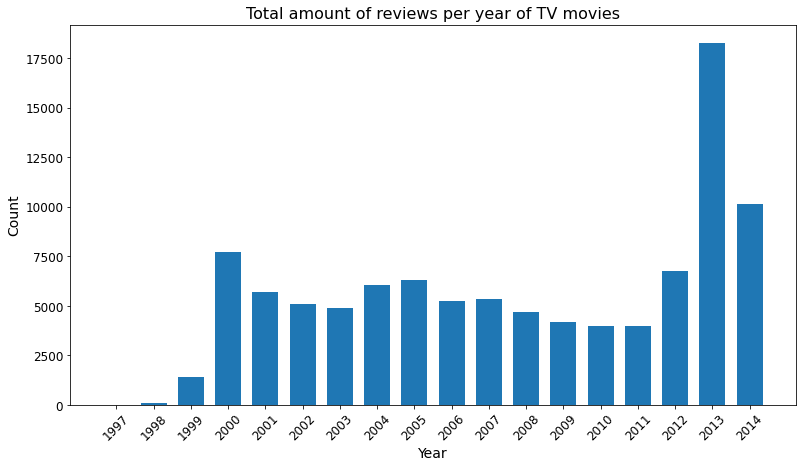

In [383]:
plt.hist(movies_tv.year, bins = range(1997,2016), rwidth = 0.7, align = 'left')
fig = plt.gcf()
ax = plt.gca()

fig.set_size_inches(13, 7)
plt.xlabel('Year', size = 14)
plt.ylabel('Count', size = 14)
plt.title('Total amount of reviews per year of TV movies', size = 16)
plt.xticks(range(1997,2015),size = 12, rotation =45)
plt.yticks(size = 12)
plt.plot()

[]

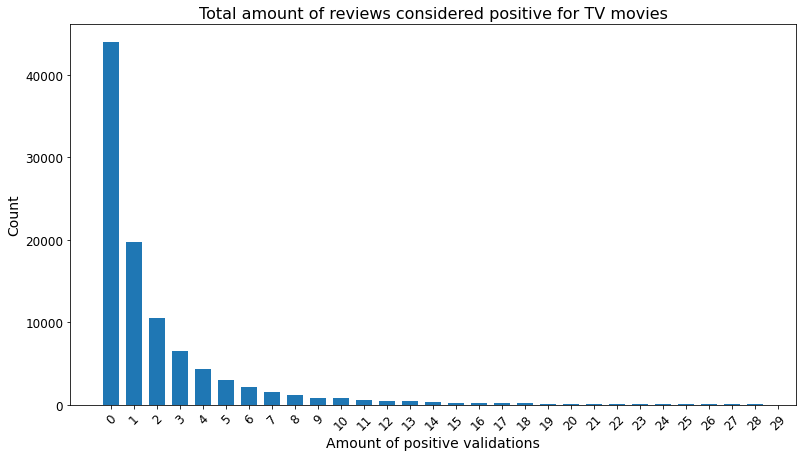

In [384]:
plt.hist(movies_tv.helpful_pos, bins=range(0,30), rwidth = 0.7, align = 'left')
fig = plt.gcf()
ax = plt.gca()

fig.set_size_inches(13, 7)
plt.xlabel('Amount of positive validations', size = 14)
plt.ylabel('Count', size = 14)
plt.title('Total amount of reviews considered positive for TV movies', size = 16)
plt.xticks(range(0,30),size = 12, rotation =45)
plt.yticks(size = 12)
plt.plot()

[]

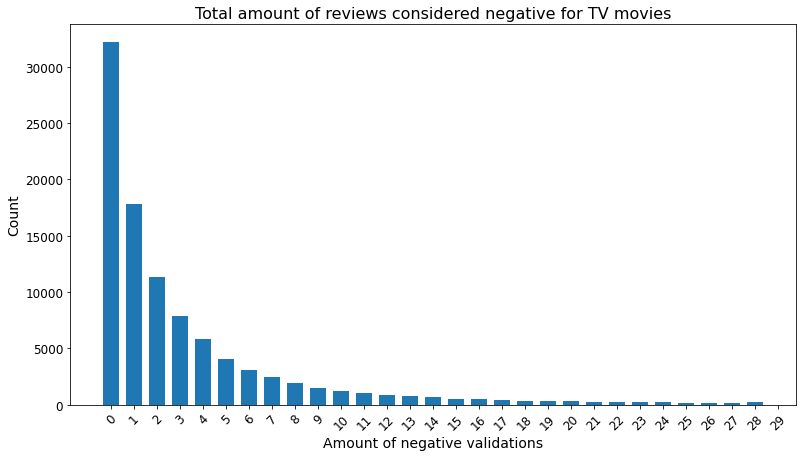

In [385]:
plt.hist(movies_tv.helpful_neg, bins=range(0,30), rwidth = 0.7, align = 'left')
fig = plt.gcf()
ax = plt.gca()

fig.set_size_inches(13, 7)
plt.xlabel('Amount of negative validations', size = 14)
plt.ylabel('Count', size = 14)
plt.title('Total amount of reviews considered negative for TV movies', size = 16)
plt.xticks(range(0,30),size = 12, rotation =45)
plt.yticks(size = 12)
plt.plot()

In [386]:
instant_video.head()
instant_video.helpful_pos.value_counts()
movies_tv.year.unique().max()

2014

[]

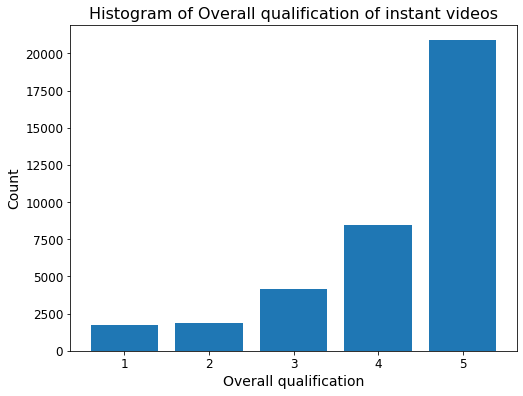

In [387]:
plt.hist(instant_video.overall, bins = [1,2,3,4,5,6], rwidth = 0.8, align = 'left')
fig = plt.gcf()
fig.set_size_inches(8, 6)
plt.xlabel('Overall qualification', size = 14)
plt.ylabel('Count', size = 14)
plt.title('Histogram of Overall qualification of instant videos', size = 16)
plt.xticks(size = 12)
plt.yticks(size = 12)

plt.plot()

[]

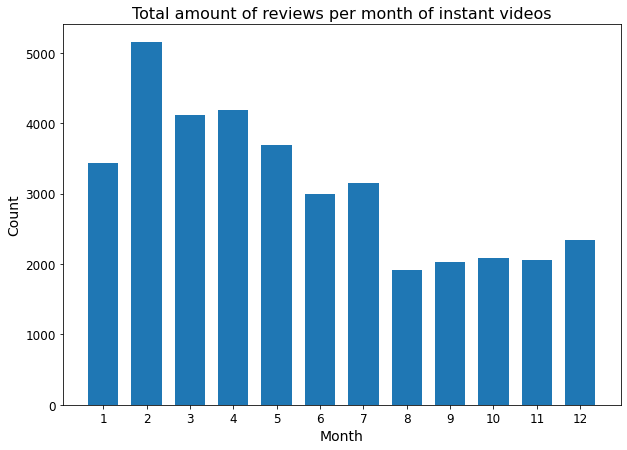

In [388]:
plt.hist(instant_video.month, bins = range(1,14), rwidth = 0.7, align = 'left')
fig = plt.gcf()
ax = plt.gca()

fig.set_size_inches(10, 7)
plt.xlabel('Month', size = 14)
plt.ylabel('Count', size = 14)
plt.title('Total amount of reviews per month of instant videos', size = 16)
plt.xticks(range(13),size = 12)
plt.yticks(size = 12)
plt.plot()

[]

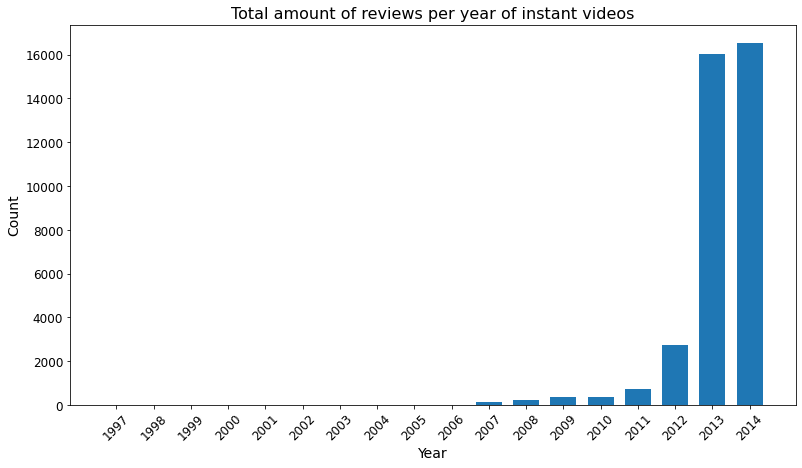

In [389]:
plt.hist(instant_video.year, bins = range(1997,2016), rwidth = 0.7, align = 'left')
fig = plt.gcf()
ax = plt.gca()

fig.set_size_inches(13, 7)
plt.xlabel('Year', size = 14)
plt.ylabel('Count', size = 14)
plt.title('Total amount of reviews per year of instant videos', size = 16)
plt.xticks(range(1997,2015),size = 12, rotation =45)
plt.yticks(size = 12)
plt.plot()

[]

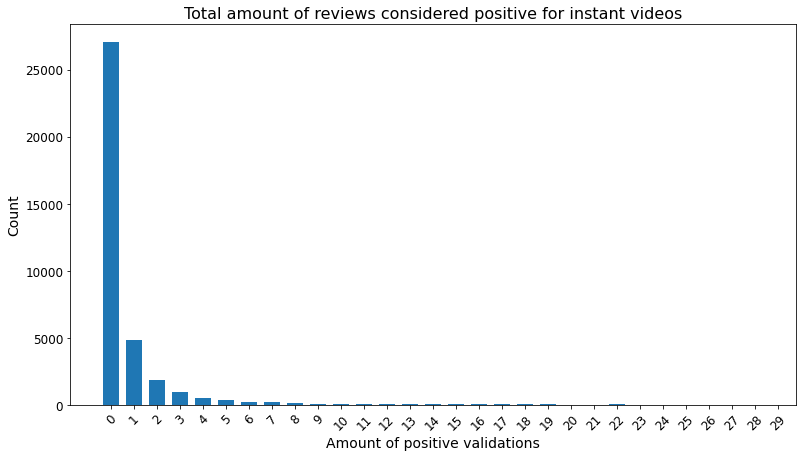

In [390]:
plt.hist(instant_video.helpful_pos, bins=range(0,30), rwidth = 0.7, align = 'left')
fig = plt.gcf()
ax = plt.gca()

fig.set_size_inches(13, 7)
plt.xlabel('Amount of positive validations', size = 14)
plt.ylabel('Count', size = 14)
plt.title('Total amount of reviews considered positive for instant videos', size = 16)
plt.xticks(range(0,30),size = 12, rotation =45)
plt.yticks(size = 12)
plt.plot()

[]

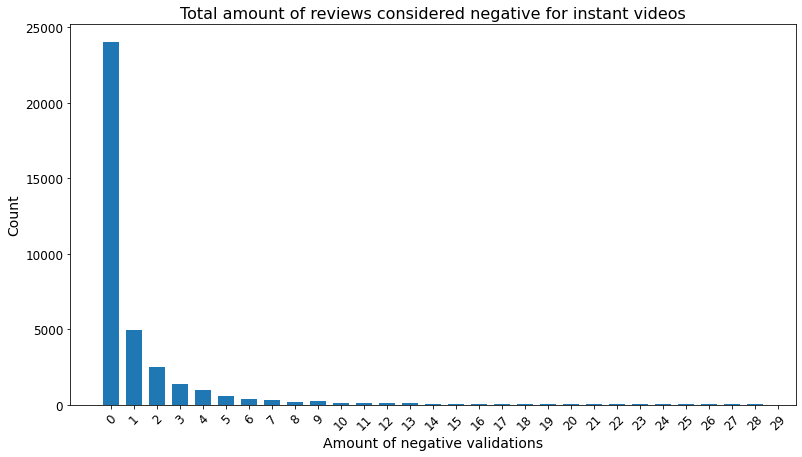

In [391]:
plt.hist(instant_video.helpful_neg, bins=range(0,30), rwidth = 0.7, align = 'left')
fig = plt.gcf()
ax = plt.gca()

fig.set_size_inches(13, 7)
plt.xlabel('Amount of negative validations', size = 14)
plt.ylabel('Count', size = 14)
plt.title('Total amount of reviews considered negative for instant videos', size = 16)
plt.xticks(range(0,30),size = 12, rotation =45)
plt.yticks(size = 12)
plt.plot()

**Answer.**

From the previous histograms, we can notice a few things about the first 100.000 TV movies reviews:

- The month with most the reviews is January, then March. February and the months April to June show a very constant amount. The amount of reviews decrease from July until September, where they start increasing again.

- It is also noticeable that a large amount of reviews were done in 2013. Followed by 2014, which had almost half the reviews.

We can notice about the instant videos that:

- The month with most the reviews is February, the amount of reviews decrease until July. After that, the amount of reviews is almost constant.

- Similar to the TV movies, the amount of reviews show a constantly increasing trend over the years. Nevertheless, 2013 and 2014 have almost the same amount of reviews.

For both TV movies and instant videos:

- We can also see how most of the reviews do not have an indication of how helpful it was.

- The review qualifications are mainly 4 and 5.

--------

#### 1.2

How do average ratings change over time? Plot the average rating for each year and note any trends.

In [392]:
tv_movies_yearrating = movies_tv[["overall","year"]].groupby("year").mean().reset_index()
insta_videos_yearrating = instant_video[["overall","year"]].groupby("year").mean().reset_index()

tv_movies_yearrating.rename(columns={"overall":"tv_movies"}, inplace=True)
insta_videos_yearrating.rename(columns={"overall":"instant_videos"}, inplace=True)
# tv_movies_yearrating

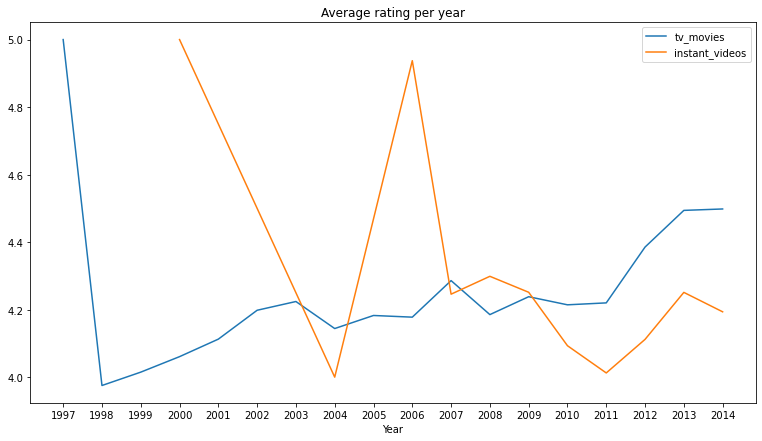

In [393]:
# tv_movies_yearrating
# insta_videos_yearrating

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(13, 7)

tv_movies_yearrating.plot(x = "year", y="tv_movies",ax=ax)
insta_videos_yearrating.plot(x = "year", y="instant_videos", ax=ax)

plt.xlabel("Year")
plt.xticks(list(tv_movies_yearrating.year))
plt.title('Average rating per year')
plt.show()

**Answer.**

About the first 100.000 reviews of TV movies:

We can see how TV movies were mostly 5 during 1997 but it quickly lowered to 4 and started growing at a very constant average until 2011. After 2011, the average qualification increased from 4.2 to around 4.5 in 2 years.

The instant videos had a very changing average rating since 2000, which is the first year we have register for. This average oscillated from 2000 to 2008. That year, the oscillations decreased and the average started decreasing until 2011, where the average started increasing again. In the last recorded year, 2013 to 2014, the average decreased again.

--------

#### 1.3

Look at the average length of the review by year. Do you notice any trends?

In [394]:
%%time
instant_video["review_len"]=instant_video.reviewText.apply(lambda x: len(nltk.word_tokenize(x)))
movies_tv["review_len"]=movies_tv.reviewText.apply(lambda x: len(nltk.word_tokenize(x)))

In [366]:
# Use amount of characters and not of words
# instant_video["review_len"]=instant_video.reviewText.apply(lambda x: len(x))
# movies_tv["review_len"]=movies_tv.reviewText.apply(lambda x: len(x))
instant_video.head()
movies_tv.head()

,helpful,reviewText,overall,summary,unixReviewTime,datetime,year,month,helpful_pos,helpful_neg,review_len
0,"[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26,2008,2,0,0,299
1,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30,2013,12,0,0,122
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30,2013,12,0,0,251
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13,2008,2,0,0,153
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22,2013,12,0,0,148


In [395]:
tv_movies_revlen = movies_tv[["review_len","year"]].groupby("year").mean().reset_index()
insta_videos_revlen = instant_video[["review_len","year"]].groupby("year").mean().reset_index()

tv_movies_revlen.rename(columns={"review_len":"tv_movies"}, inplace=True)
insta_videos_revlen.rename(columns={"review_len":"instant_videos"}, inplace=True)

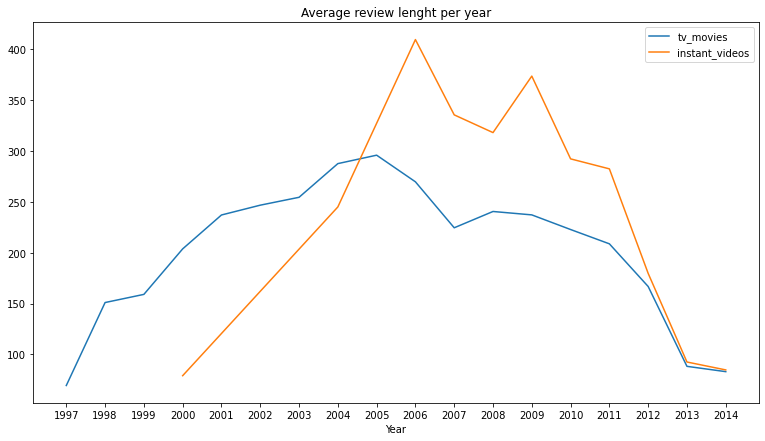

In [396]:
ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(13, 7)

tv_movies_revlen.plot(x = "year", y="tv_movies",ax=ax)
insta_videos_revlen.plot(x = "year", y="instant_videos", ax=ax)

plt.xlabel("Year")
plt.xticks(list(tv_movies_revlen.year))
plt.title('Average review lenght per year')
plt.show()

**Answer.**

In both data frames we can see a trend of negative concavity. This means that when the data began to be recorded, the lenght of the review was low, around 100 words in both dataframes, and increased to a maximum in the year 2005 in the case of TV movies and 2006 in the case of instant videos. It's also noticeable how the lenght of the instant videos review increased much faster and up to 400 words, while TV movies were always below 300. After this year of maximum, the lenght of the reviews decreased (with a few oscillations in the case of instant videos) up to the last recorded year 2014.

--------

### Exercise 2:

#### 2.1

Find the ten most frequently occuring non-stop words acrooss: (i) all reviews, (ii) positive reviews, (iii) negative reviews. Do the results surprise you? Why or why not?

In [649]:
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def top_k_ngrams(word_tokens,n,k):
    
    ## Getting them as n-grams
    n_gram_list = list(ngrams(word_tokens, n))

    ### Getting each n-gram as a separate string
    n_gram_strings = [' '.join(each) for each in n_gram_list]
    
    n_gram_counter = Counter(n_gram_strings)
    most_common_k = n_gram_counter.most_common(k)
#     print(most_common_k)
    
#     x_pos = [k for k,v in most_common_k]
#     y_pos = [v for k,v in most_common_k]
    
#     plt.bar(x_pos, y_pos,align='center')
    return most_common_k

In [667]:
%%time

from nltk.corpus import stopwords
import string

eng_stopwords = stopwords.words('english')

### Getting a single string
all_reviews_text = ' '.join(instant_video.reviewText)
all_reviews_text2 = ' '.join(movies_tv.reviewText)

## Splitting them into tokens
word_tokens = nltk.word_tokenize(all_reviews_text)
word_tokens2 = nltk.word_tokenize(all_reviews_text2)

## Removing the stopwords
word_tokens_clean = [each for each in word_tokens if each.lower() not in eng_stopwords and len(each.lower()) > 2]
word_tokens_clean2 = [each for each in word_tokens2 if each.lower() not in eng_stopwords and len(each.lower()) > 2]

## Calling the function for top k
print("The most frequent non-stop words for Instant videos are: \n")
most_common_k_iv = top_k_ngrams(word_tokens_clean, 1, 20)
print(most_common_k_iv)
print()
print("The most frequent non-stop words for TV movies are: \n")
most_common_k_tv = top_k_ngrams(word_tokens_clean2, 1, 20)
print(most_common_k_tv)

The most frequent non-stop words for Instant videos are: 

[('show', 24612), ("n't", 19635), ('like', 13958), ('season', 13122), ('one', 12980), ('series', 12278), ('good', 11149), ('really', 8489), ('watch', 8445), ('great', 8429), ('characters', 8395), ('would', 8332), ('story', 7553), ('see', 7363), ('love', 7304), ('movie', 7237), ('get', 6925), ('episode', 6909), ('well', 6553), ('time', 6496)]

The most frequent non-stop words for TV movies are: 

[('movie', 139213), ('film', 112720), ("n't", 77150), ('one', 73546), ('like', 46075), ('quot', 44715), ('good', 40461), ('great', 40150), ('time', 35776), ('story', 33270), ('would', 32013), ('see', 28955), ('really', 28037), ('well', 26434), ('...', 26322), ('much', 25556), ('get', 25286), ('first', 25079), ('movies', 24642), ('also', 24567)]
Wall time: 2min 32s


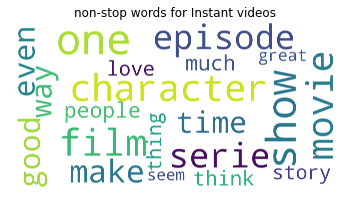

In [669]:
wordcloud = WordCloud(max_font_size=100, max_words=20, background_color="white",\
                          scale = 10,width=800, height=400).generate(' '.join(word_tokens_clean))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("non-stop words for Instant videos")
plt.show()

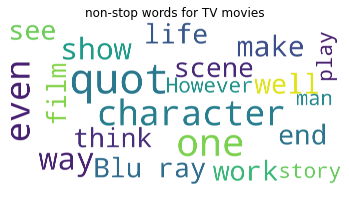

In [670]:
wordcloud = WordCloud(max_font_size=100, max_words=20, background_color="white",\
                          scale = 10,width=800, height=400).generate(' '.join(word_tokens_clean2))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("non-stop words for TV movies")
plt.show()

In [671]:
%%time

### Getting a single string
all_reviews_text = ' '.join(instant_video[instant_video.overall > 3].reviewText)
all_reviews_text2 = ' '.join(movies_tv[movies_tv.overall > 3].reviewText)

## Splitting them into tokens
word_tokens = nltk.word_tokenize(all_reviews_text)
word_tokens2 = nltk.word_tokenize(all_reviews_text2)

## Removing the stopwords
word_tokens_clean = [each for each in word_tokens if each.lower() not in eng_stopwords and len(each.lower()) > 2]
word_tokens_clean2 = [each for each in word_tokens2 if each.lower() not in eng_stopwords and len(each.lower()) > 2]

## Calling the function for top k
print("The most frequent non-stop words for Instant videos in positive reviews are: \n")
most_common_k_iv = top_k_ngrams(word_tokens_clean, 1, 20)
print(most_common_k_iv)
print()

print("The most frequent non-stop words for TV movies in positive reviews are: \n")
most_common_k_tv = top_k_ngrams(word_tokens_clean2, 1, 20)
print(most_common_k_tv)

The most frequent non-stop words for Instant videos in positive reviews are: 

[('show', 19841), ("n't", 12572), ('season', 11076), ('series', 10386), ('like', 9643), ('one', 9447), ('good', 8462), ('great', 7324), ('characters', 6465), ('watch', 6464), ('love', 6409), ('really', 6079), ('see', 5671), ('would', 5507), ('story', 5395), ('episode', 5387), ('well', 5360), ('get', 4849), ('time', 4564), ('watching', 4345)]

The most frequent non-stop words for TV movies in positive reviews are: 

[('movie', 110044), ('film', 89657), ('one', 59976), ("n't", 55332), ('great', 35291), ('quot', 34366), ('like', 34274), ('good', 30901), ('time', 29355), ('story', 26893), ('would', 23373), ('see', 23146), ('well', 21996), ('really', 21303), ('best', 20976), ('also', 20668), ('...', 20308), ('movies', 20240), ('first', 20036), ('love', 19665)]
Wall time: 1min 59s


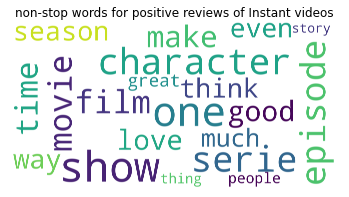

In [672]:
wordcloud = WordCloud(max_font_size=100, max_words=20, background_color="white",\
                          scale = 10,width=800, height=400).generate(' '.join(word_tokens_clean))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("non-stop words for positive reviews of Instant videos")
plt.show()

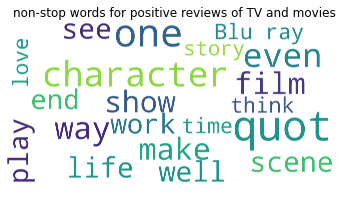

In [673]:
wordcloud = WordCloud(max_font_size=100, max_words=20, background_color="white",\
                          scale = 10,width=800, height=400).generate(' '.join(word_tokens_clean2))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("non-stop words for positive reviews of TV and movies")
plt.show()

In [674]:
%%time

### Getting a single string
all_reviews_text = ' '.join(instant_video[instant_video.overall < 3].reviewText)
all_reviews_text2 = ' '.join(movies_tv[movies_tv.overall < 3].reviewText)

## Splitting them into tokens
word_tokens = nltk.word_tokenize(all_reviews_text)
word_tokens2 = nltk.word_tokenize(all_reviews_text2)

## Removing the stopwords
word_tokens_clean = [each for each in word_tokens if each.lower() not in eng_stopwords and len(each.lower()) > 2]
word_tokens_clean2 = [each for each in word_tokens2 if each.lower() not in eng_stopwords and len(each.lower()) > 2]

## Calling the function for top k
print("The most frequent non-stop words for Instant videos in negative reviews are: \n")
most_common_k_iv = top_k_ngrams(word_tokens_clean, 1, 20)
print(most_common_k_iv)
print()
print("The most frequent non-stop words for TV movies in negative reviews are: \n")
most_common_k_tv = top_k_ngrams(word_tokens_clean2, 1, 20)
print(most_common_k_tv)

The most frequent non-stop words for Instant videos in negative reviews are: 

[("n't", 3461), ('show', 2170), ('like', 2021), ('movie', 1677), ('one', 1673), ('would', 1307), ('film', 1156), ('really', 1069), ('good', 1067), ('...', 1010), ('get', 954), ('time', 938), ('could', 902), ('watch', 899), ('people', 897), ('story', 890), ('much', 869), ('characters', 867), ('even', 844), ('bad', 788)]

The most frequent non-stop words for TV movies in negative reviews are: 

[('movie', 15331), ("n't", 11392), ('film', 10328), ('one', 6732), ('like', 6029), ('quot', 5348), ('would', 4364), ('good', 3934), ('even', 3470), ('...', 3267), ('really', 3146), ('time', 3088), ('could', 2992), ('much', 2982), ('get', 2918), ('see', 2905), ('story', 2804), ('bad', 2619), ('people', 2424), ('first', 2308)]
Wall time: 17 s


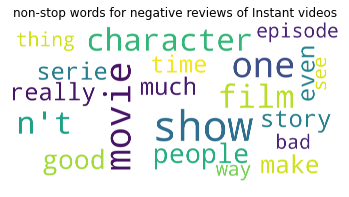

In [675]:
wordcloud = WordCloud(max_font_size=100, max_words=20, background_color="white",\
                          scale = 10,width=800, height=400).generate(' '.join(word_tokens_clean))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("non-stop words for negative reviews of Instant videos")
plt.show()

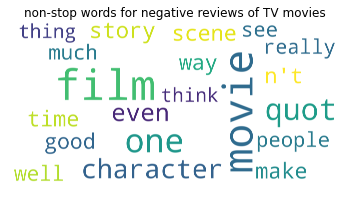

In [676]:
wordcloud = WordCloud(max_font_size=100, max_words=20, background_color="white",\
                          scale = 10,width=800, height=400).generate(' '.join(word_tokens_clean2))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("non-stop words for negative reviews of TV movies")
plt.show()

**Answer.**

By looking at the most common non-stop words in all reviews we can see that the words mostly related to the structure of a show or movie, such as: character, movie, film, serie. Some other words are interesting to note such as "good" which appears in all reviews, negative and positive as a common word.

The words in positive reviews are similar to the general reviews. Nevertheless, words like great, love, well, good.

The words in negative reviews do not show many evident words of negative perspectives. The most remarkable words can be "good", "bad" and "n't". The latter comes from the negation which can imply the negation of positive aspects.

--------

 #### 2.2

Find words that are indicative of bad reviews. That is, words that appear often in bad reviews and *not* in good reviews. What are these words and are they surprising?

In [681]:
%%time

### Getting a single string
all_reviews_text = ' '.join(instant_video[instant_video.overall < 3].reviewText)
all_reviews_text2 = ' '.join(instant_video[instant_video.overall > 3].reviewText)

## Splitting them into tokens
word_tokens = nltk.word_tokenize(all_reviews_text)
word_tokens2 = nltk.word_tokenize(all_reviews_text2)

## Removing the stopwords
word_tokens_clean = [each for each in word_tokens if each.lower() not in eng_stopwords and len(each.lower()) > 2]
word_tokens_clean2 = [each for each in word_tokens2 if each.lower() not in eng_stopwords and len(each.lower()) > 2]

## Calling the function for top k
top_neg_words = top_k_ngrams(word_tokens_clean, 1, 100)
top_pos_words = top_k_ngrams(word_tokens_clean2, 1, 100)

selected_neg_words = [k for k,v in top_neg_words]
# print(selected_neg_words,"\n",top_pos_words,"\n")

for k,v in top_pos_words:
    
    if k in selected_neg_words: 
        selected_neg_words.remove(k)

top_neg_words_exclude_pos = [(k,v) for k,v in top_neg_words if k in selected_neg_words]

    
print("The most frequenty non-stop words for Instant videos in negative reviews not included in positive reviews are: \n")
print(top_neg_words_exclude_pos)

The most frequenty non-stop words for Instant videos in negative reviews not included in positive reviews are: 

[('8217', 535), ('minutes', 410), ('thing', 407), ('nothing', 407), ('seems', 393), ("'re", 379), ('found', 338), ('give', 332), ('boring', 328), ('around', 324), ('anything', 307), ('got', 303), ('movies', 302), ('pretty', 290), ('thought', 282), ('trying', 278), ('long', 276), ('actually', 275), ('take', 268), ('guy', 266), ('ever', 266), ('waste', 260), ('care', 257), ('might', 257), ('least', 253)]
Wall time: 23 s


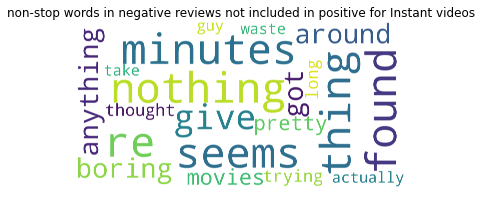

In [682]:
wordcloud = WordCloud(max_font_size=100, max_words=20, background_color="white",\
                          scale = 10,width=800, height=400).generate(' '.join(selected_neg_words))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("non-stop words in negative reviews not included in positive for Instant videos")
plt.show()

In [683]:
%%time

### Getting a single string
all_reviews_text = ' '.join(movies_tv[movies_tv.overall < 3].reviewText)
all_reviews_text2 = ' '.join(movies_tv[movies_tv.overall > 3].reviewText)

## Splitting them into tokens
word_tokens = nltk.word_tokenize(all_reviews_text)
word_tokens2 = nltk.word_tokenize(all_reviews_text2)

## Removing the stopwords
word_tokens_clean = [each for each in word_tokens if each.lower() not in eng_stopwords and len(each.lower()) > 2]
word_tokens_clean2 = [each for each in word_tokens2 if each.lower() not in eng_stopwords and len(each.lower()) > 2]

## Calling the function for top k
top_neg_words = top_k_ngrams(word_tokens_clean, 1, 100)
top_pos_words = top_k_ngrams(word_tokens_clean2, 1, 100)

selected_neg_words = [k for k,v in top_neg_words]
# print(selected_neg_words,"\n",top_pos_words,"\n")

for k,v in top_pos_words:
    
    if k in selected_neg_words: 
        selected_neg_words.remove(k)

top_neg_words_exclude_pos_tv = [(k,v) for k,v in top_neg_words if k in selected_neg_words]

    
print("The most frequenty non-stop words for TV movies in negative reviews not included in positive reviews are: \n")
print(top_neg_words_exclude_pos_tv)

The most frequenty non-stop words for TV movies in negative reviews not included in positive reviews are: 

[('bad', 2619), ('nothing', 1375), ('thing', 1375), ("'re", 1228), ('got', 1116), ('actually', 1115), ('give', 1072), ('thought', 1069), ('enough', 1049), ('seems', 1048), ('least', 993), ('far', 966), ('fact', 964), ('point', 956), ('director', 954), ('money', 950), ('pretty', 948), ('around', 935), ('whole', 934), ('big', 910), ('anything', 895), ('worst', 895)]
Wall time: 1min 52s


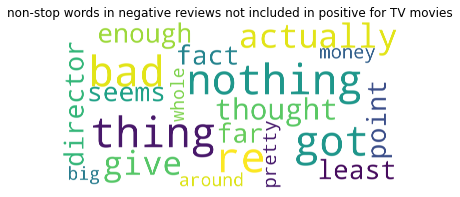

In [684]:
wordcloud = WordCloud(max_font_size=100, max_words=20, background_color="white",\
                          scale = 10,width=800, height=400).generate(' '.join(selected_neg_words))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("non-stop words in negative reviews not included in positive for TV movies")
plt.show()

**Answer.**

After filtering the words of negative reviews that are not in positive reviews. We obtained words that manifest explicitly negative emotions such as: "nothing", "boring", "bad", "enough", "least" or "waste". This defintely is surprising. As we can see, these words are much less frequent than the most common words in negative reviews (that also happen to be in positive reviews).

--------

### Exercise 3:

Manually inspect the first 10 negative reviews containing the word "good". What do you notice? How does this suggest we ought to proceed next?

In [479]:
count = 1
i = 0
first_10_reviews_insta = list()

print("First 10 reviews of Instant videos with the word \"good\" and a bad score: \n")
while count <= 10:
    if "good" in instant_video.reviewText[i] and instant_video.overall[i] < 3:
        first_10_reviews_insta.append(instant_video.reviewText[i])
        print(count, ": ", instant_video.reviewText[i], "\n")
        count += 1
    i += 1


First 10 reviews of Instant videos with the word "good" and a bad score: 

1 :  I watched this because the Brits usually do a good job with good production values, casting and story lines.  However, in this case it proved a waste of 5 hours. The writers, directors and editors should be ashamed to put their names in the credits.  Important things happen with no apparent reason and the watcher is left scratching his/her head wondering what was the point.  The American general is miscast and not believable.  Lots of clicking of computer keyboards for solutions that never seem to work out. The ending stinks! 

2 :  You know the plot. Trashy kids being trashy. The &#34;good&#34; ones are the &#34;poor&#34; ones. The rich trashy kids are just &#34;bad&#34;. Another movie to help the retarded careers of this TV show's actors. They are all old and washed out. But they still try to be hip and cool with their texting and foul mouths, sex videos. Sorry if you can't route for the heroine of the mo

In [480]:
count = 1
i = 0
first_10_reviews_movie = list()

print("First 10 reviews of TV movies with the word \"good\" and a bad score \n")
while count <= 10:
    if "good" in movies_tv.reviewText[i] and movies_tv.overall[i] < 3:
        first_10_reviews_movie.append(movies_tv.reviewText[i])
        print(count, ": ", movies_tv.reviewText[i], "\n")
        count += 1
    i += 1


First 10 reviews of TV movies with the word "good" and a bad score 

1 :  The acting was good, the story was correct, but naked backsides was not necessary.  Also the Potiphers wife did not need to be so very seductive of a naked Joseph. Not a Christian movie.  I felt that even though it was probably portrayed truthfully, Christans do not need to see so explicit a scene.  This should be rated PG 13 at least. 

2 :  The DVD transfer is pretty good but the scene with Yukon discovering peppermint has been cut.It seems pretty odd to sell a DVD as a restored classic only to leave out the main thing that was to be restored! 

3 :  ANOTHER American cultural icon from the 60's has beendeemed unacceptable by those who would prefer to seemalice where none exists.Not even Underdog can escape the slings and arrows ofthose with the same mentality as the book-burners of1930's Germany.Why do we allow such obvious Orwellian "Newsspeak" toedit our past? Come on... this IS a cartoon, for Pete'ssake, NOT

**Answer.**

We can notice that the word "good" is mainly use in three ways in negative reviews. First, it is used to describe a positive aspect of the writers, movie or show before explicitly mentioning the aspects that express negative opinions/emotions. Then, the word "good" is also used in negation such as "this aspect is not good". Finally, the word "good" is also used as comparative in sentences such as "it did more damage than good".

--------

### Exercise 4:

Go through the list of bad reviews containing the word "good" that we found in the last question. For each review, extract the following:

1. The first word after "good"
2. The first word after "good" that is a noun or cardinal
3. The last word before "good" that is a noun or cardinal

In [544]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dcalle.MATONE\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [644]:
def ExtractInteresting(sentence, match = ["NN","CD"]):
    words = nltk.word_tokenize(sentence)
    interesting = [k for k,v in nltk.pos_tag(words) if v in match]
    return(interesting)

def next_word(sentence):

    items = list()
    word_tokens = nltk.word_tokenize(sentence)
    
    if "good" not in word_tokens: return ""
    
    while "good" in word_tokens:
        idx = word_tokens.index("good")
        pos_words = [k for k,v in nltk.pos_tag(word_tokens[idx:]) if v in ["NN","CD"]]
        if len(pos_words) > 0: items.append(pos_words[0])
        del word_tokens[idx]
    
    return items
    
def prev_word(sentence):
    items = list()
    word_tokens = nltk.word_tokenize(sentence)
    
    if "good" not in word_tokens: return ""
    
    while "good" in word_tokens:
        idx = word_tokens.index("good")
        pos_words = [k for k,v in nltk.pos_tag(word_tokens[:idx]) if v in ["NN","CD"]]
        if len(pos_words) > 0: items.append(pos_words[-1])      #take the last element since it is the one before "good"
        del word_tokens[idx]
    
    return items

In [639]:
import re

print("First word after \"good\" in Instant movies reviews:\n")
for sentence in first_10_reviews_insta:
    out = re.findall(r"good (.\w*)", sentence)
    print(out)

# re.findall(r".*good", first_10_reviews_insta[0])
# nltk.word_tokenize(first_10_reviews_insta[0])

First word after "good" in Instant movies reviews:

['job', 'production']
[]
['movie']
['for']
[]
['TV']
['but']
[]
['acting']
['actors']


In [685]:
after_good = []
ind = 0
for sentence in first_10_reviews_insta:
    temp = next_word(sentence)
    after_good = after_good + temp #This is used to concatenate lists!
    
nonempty = [i for i in after_good if i] 
print("\nFirst noun/cardinal after \"good\" in Instant videos reviews:\n",nonempty[0:15])

prev_good = []
ind = 0
for sentence in first_10_reviews_insta:
    temp = prev_word(sentence)
    prev_good = prev_good + temp
    
nonempty = [i for i in prev_good if i] 
print("\nFirst noun/cardinal before \"good\" in Instant videos reviews:\n",nonempty[0:15])


First noun/cardinal after "good" in Instant videos reviews:
 ['job', 'production', '34', 'movie', 'set', 'Yuck', 'TV', 'rest', 'way', 'acting', 'fact']

First noun/cardinal before "good" in Instant videos reviews:
 ['job', '34', 'movie', 'writing', 'two', 'beetch', 'line', 'dvd', 'plot', 'Captain']


In [686]:
print("First word after \"good\" in TV movies reviews:\n")
for sentence in first_10_reviews_movie:
    out = re.findall(r"good (.\w*)", sentence)
    print(out)

First word after "good" in TV movies reviews:

[]
['but']
['vs']
['plot']
['cinema']
['and']
[]
['as', 'one']
['Christians']
['parts', 'filter', 'and', 'movie', 'enough']


In [688]:
after_good = []
ind = 0
for sentence in first_10_reviews_movie:
    temp = next_word(sentence)
    after_good = after_good + temp #This is used to concatenate lists!
    
nonempty = [i for i in after_good if i] 
print("First noun/cardinal after \"good\" in TV movies reviews:\n",nonempty[0:15])

prev_good = []
ind = 0
for sentence in first_10_reviews_movie:
    temp = prev_word(sentence)
    prev_good = prev_good + temp
    
nonempty = [i for i in prev_good if i] 
print("\nFirst noun/cardinal before \"good\" in TV movies reviews:\n",nonempty[0:15])

First noun/cardinal after "good" in TV movies reviews:
 ['story', 'scene', 'evil', 'plot', 'cinema', 'history', 'anyone', 'fan', 'one', 'side', 'ancient', 'filter', 'landscape', 'movie', 'job']

First noun/cardinal before "good" in TV movies reviews:
 ['acting', 'transfer', 'statement.Nothing', 'story', 'everything', 'acting', 'damage', 'film', 'movie', 'Point', 'advance', 'movie.First', 'film', 'city', 'soundtrack']


**Answer.**

From this exploration, we can clearly see how the words right next to "good" do not provide, in general, information that complements the understanding of why or how "good" is used in negative reviews more commonly.

It is also clearly necessary to explore parts-of-speech to understand the usage of "good" as we saw by extracting the nouns and cardinals after and before the word of interest.

--------

### Exercise 5:

We have seen that individual words are not always very informative. Look for the most informative bigrams and trigrams, in both positive and negative reviews. Show the most informative bigrams and trigrams and give a brief analysis of the n-grams you identified.

In [609]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_words(corpus, n=1,k=1):
    vec = CountVectorizer(ngram_range=(k,k),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

waste time 150
story line 116
ve seen 114
don know 102
sci fi 92
don think 81
34 34 79
looks like 75
high school 64
special effects 63
don care 63
felt like 63
don waste 60
main character 60
wanted like 57


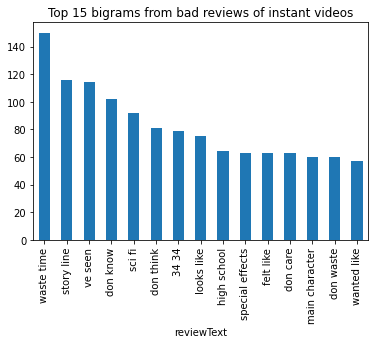

In [691]:
# Get top bigrams from bad reviews of instant videos
common_words = get_top_n_words(instant_video[instant_video.overall < 3].reviewText, 15,2)

for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns = ['reviewText' , 'count'])
df.groupby('reviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 15 bigrams from bad reviews of instant videos')

plt.show()

# instant_video[instant_video.overall < 3].reviewText
# movies_tv[movies_tv.overall < 3].reviewText

story line 944
second season 643
sci fi 588
story lines 566
ve seen 564
looking forward 539
highly recommend 538
worth watching 503
fun watch 483
amazon prime 480
look forward 479
wait season 466
year old 462
really good 455
don know 448


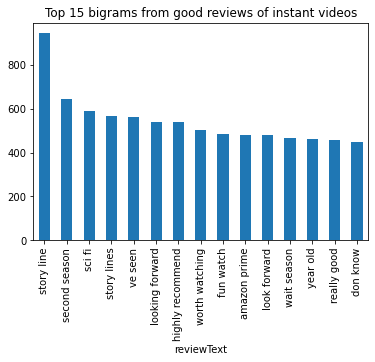

In [692]:
# Get top bigrams from good reviews of instant videos
common_words = get_top_n_words(instant_video[instant_video.overall > 3].reviewText, 15,2)

for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns = ['reviewText' , 'count'])
df.groupby('reviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 15 bigrams from good reviews of instant videos')

plt.show()

# instant_video[instant_video.overall < 3].reviewText
# movies_tv[movies_tv.overall < 3].reviewText

don waste time 43
really wanted like 24
parental guide bomb 14
big bang theory 13
waste time money 12
bad acting bad 12
don waste money 10
dvd distribution handled 10
note following review 10
following review contain 10
reader prefers review 10
prefers review entirely 10
review entirely spoiler 10
entirely spoiler free 10
34 lost 34 10


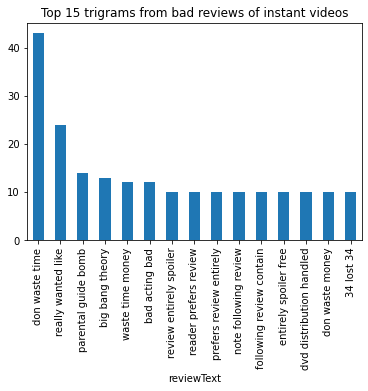

In [693]:
# Get top trigrams from bad reviews of instant videos
common_words = get_top_n_words(instant_video[instant_video.overall < 3].reviewText, 15,3)

for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns = ['reviewText' , 'count'])
df.groupby('reviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 15 trigrams from bad reviews of instant videos')

plt.show()

looking forward season 164
keeps getting better 106
great story line 98
love love love 92
does great job 92
good story line 88
just keeps getting 83
gets better better 82
amazon instant video 80
did great job 77
look forward season 70
getting better better 65
new york city 63
look forward seeing 62
big bang theory 59


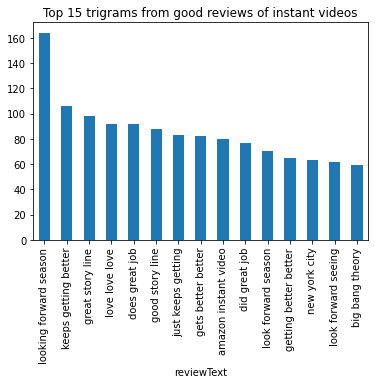

In [695]:
# Get top trigrams from good reviews of instant videos
common_words = get_top_n_words(instant_video[instant_video.overall > 3].reviewText, 15,3)

for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns = ['reviewText' , 'count'])
df.groupby('reviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 15 trigrams from good reviews of instant videos')

plt.show()

blu ray 685
special effects 557
ve seen 450
movie just 395
waste time 385
don know 384
quot quot 303
good movie 267
looks like 252
like movie 239
look like 236
sci fi 233
years ago 203
year old 201
movie like 197


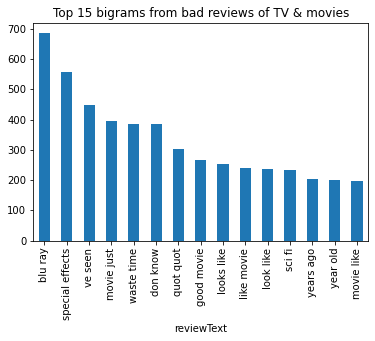

In [696]:
# Get top bigrams from bad reviews of TV movies
common_words = get_top_n_words(movies_tv[movies_tv.overall < 3].reviewText, 15,2)

for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns = ['reviewText' , 'count'])
df.groupby('reviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 15 bigrams from bad reviews of TV & movies')

plt.show()

# instant_video[instant_video.overall < 3].reviewText
# movies_tv[movies_tv.overall < 3].reviewText

blu ray 6714
great movie 4300
ve seen 3895
special effects 3830
good movie 2669
love movie 2509
sci fi 2246
years ago 2191
movie great 2152
quot quot 1935
black white 1927
special features 1874
watch movie 1853
don know 1824
highly recommend 1812


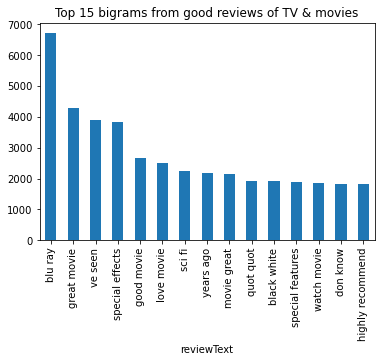

In [697]:
# Get top bigrams from good reviews of TV videos
common_words = get_top_n_words(movies_tv[movies_tv.overall > 3].reviewText, 15,2)

for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns = ['reviewText' , 'count'])
df.groupby('reviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 15 bigrams from good reviews of TV & movies')

plt.show()

# instant_video[instant_video.overall < 3].reviewText
# movies_tv[movies_tv.overall < 3].reviewText

nightmare elm street 98
tommy lee jones 89
don waste time 80
texas chainsaw massacre 63
don waste money 59
waste time money 50
blu ray version 48
catherine zeta jones 42
blu ray release 39
doesn make sense 38
blu ray player 37
movies ve seen 37
gus van sant 36
didn like movie 35
movie ve seen 34


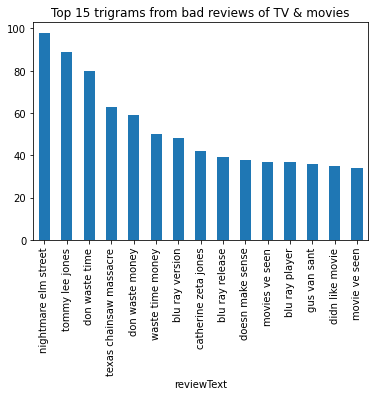

In [698]:
# Get top trigrams from bad reviews of TV videos
common_words = get_top_n_words(movies_tv[movies_tv.overall < 3].reviewText, 15,3)

for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns = ['reviewText' , 'count'])
df.groupby('reviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 15 trigrams from bad reviews of TV & movies')

plt.show()

tommy lee jones 779
nightmare elm street 640
does great job 467
world war ii 456
did great job 433
new york city 427
blu ray version 412
ve seen movie 383
highly recommend movie 350
based true story 344
blu ray release 316
does good job 310
did good job 283
country old men 273
special edition dvd 265


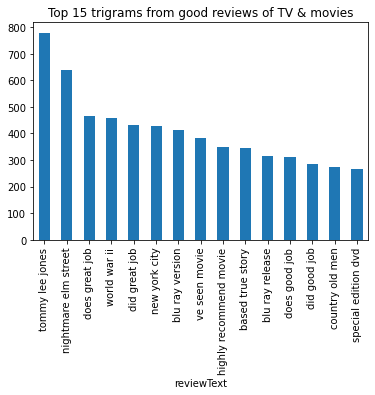

In [699]:
# Get top trigrams from good reviews of TV videos
common_words = get_top_n_words(movies_tv[movies_tv.overall > 3].reviewText, 15,3)

for word, freq in common_words:
    print(word, freq)

df = pd.DataFrame(common_words, columns = ['reviewText' , 'count'])
df.groupby('reviewText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 15 trigrams from good reviews of TV & movies')

plt.show()

**Answer.**

Regarding the Instant videos, we can see that the bad reviews 2-grams and 3-grams include a lot of expresions of negations, such as "dont like", "dont waste time", "waste time", "dont know", "waste time money". These clearly manifest negative reviews. Other n-grams seem to gather general information about the reviews themselves, such as names, expressions and comments on the review such as "review spoiler free".

This pattern is similar in the bad reviews 2-grams of the TV & movies. Nevertheless, the 3-grams contain a bunch of names related to movies and actors. This is probably referencing a typical movie or actor.

When we observe the positive reviews of Instant videos, the 2-grams and 3-grams are clearly positive with words such as "looking forward", "looking forward season", "keeps getting better", "great movie", "did great job". These are also repeated in TV & movies. Also, 3-grams of TV & movies refer to the same actors and movies that appeared in the negative 3-grams. This situation shows how very similar expressions are used for both positive and negative reviews and further/deeper analysis is required to understand the n-grams that characterize only negative reviews and only positive reviews.

It is also noticeable that the repeated n-grams in positive and negative reviews clearly give information about the general structure of the reviews and could be used to characterize the reviewers themselves.

--------

### Exercise 6:

Throughout the above search for informative words, we have seen that unigrams are not enough, but important words (such as "good") are not always next to the informative words that they describe. Devise a method to extract these informative words. Provide a brief description of how you will extract the informative words.

**Answer.**

If we find the noun/cardinal next and before the word "good". We can also get valuable information by finding the closest verb to the word "good" without passing a punctuation sign. With this, we can get more information on the real meaning of the word in context.

This can be achieved first by locating the word "good" using regular expressions or tokenizing the string where it is to be found and getting it's index. Then, we can search for the noun/cardinal in the index higher than the one previously found. The verb can be obtained in a similar way, considering indexes lower and higher than the one from "good".

--------

### Exercise 7:

Write a function(s) that transforms a sentence into a new text list by iteratively pairing each adjective in the sentence with the next noun that follows it in the sentence. For example, the text "That was a good, long movie" should return `["good movie", "long movie"]`.

**Answer.**

In [620]:
def get_next_noun(sentence):
    items = list()
    word_tokens = nltk.word_tokenize(sentence)
    adjectives = [k for k,v in nltk.pos_tag(word_tokens) if v in ["JJ", "JJR", "JJS"]]
    for adjective in adjectives:
        idx = word_tokens.index(adjective)
        pos_words = [k for k,v in nltk.pos_tag(word_tokens[idx:]) if v == "NN"]
        items.append(adjective + " " + pos_words[0])
        del word_tokens[idx]
    
    return items

sentence = "That was a good, long movie"

items = get_next_noun(sentence)
print(items)

['good movie', 'long movie']


--------